# Data Prep

## Parse the json

In [3]:
import json
with open('../solve/data/Json/graph_out.json', 'r') as f:
    adjacency_list = json.load(f)

## Convert to `edge_index` for PyTorch

In [12]:
import torch
from torch_geometric.data import Data

# Map node names (strings) to indices (integers)
node_mapping = {node: idx for idx, node in enumerate(adjacency_list.keys())}

# Create edge indices with numerical node IDs
edges = []
for node, neighbors in adjacency_list.items():
    for neighbor in neighbors:
        edges.append((node_mapping[node], node_mapping[neighbor]))

# Convert to tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_index


tensor([[   0,    0,    2,  ..., 4907, 4908, 4909],
        [3154, 4542,  923,  ..., 4909, 2976, 2978]])

## Construct default `node_features` matrix

In [ ]:
num_nodes = len(adjacency_list)
node_features = torch.eye(num_nodes)

4910

## Extract labels `y`

In [40]:
# Extract labels for each node based on the subject
node_labels = {}
for node in adjacency_list.keys():
    # Extract the subject (second component after the first dot)
    subject = node.split('.')[1] if '.' in node else "Unknown"
    node_labels[node] = subject

label_mapping = {label: idx for idx, label in enumerate(set(node_labels.values()))}
y = [label_mapping[label] for label in node_labels.values()]
y = torch.tensor(y, dtype=torch.long)

## Import to torch_geometric Data

In [41]:
data = Data(x=node_features, edge_index=edge_index, y=y)

## Do a train-val-test split

In [42]:
# Define the number of nodes
num_nodes = data.num_nodes

# Train-test split proportions
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Randomly shuffle node indices
indices = torch.randperm(num_nodes)

# Split indices
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

# Create masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

# Build GCN and train it

In [43]:
# Build a one-layer GCN
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels = 16):
        super().__init__()
        self.gcn = GCNConv(data.num_features, hidden_channels)
        self.out = Linear(hidden_channels, len(label_mapping))

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

Epoch:   0, Loss: 3.3007, Accuracy:   9.06%
Epoch:  10, Loss: 2.9441, Accuracy:  23.52%
Epoch:  20, Loss: 2.2933, Accuracy:  54.74%
Epoch:  30, Loss: 1.6428, Accuracy:  71.77%
Epoch:  40, Loss: 1.1178, Accuracy:  80.14%
Epoch:  50, Loss: 0.7461, Accuracy:  87.17%
Epoch:  60, Loss: 0.5090, Accuracy:  90.30%
Epoch:  70, Loss: 0.3554, Accuracy:  93.84%
Epoch:  80, Loss: 0.2509, Accuracy:  96.36%
Epoch:  90, Loss: 0.1809, Accuracy:  97.40%
Epoch: 100, Loss: 0.1343, Accuracy:  97.94%
Epoch: 110, Loss: 0.1025, Accuracy:  98.70%
Epoch: 120, Loss: 0.0797, Accuracy:  99.06%
Epoch: 130, Loss: 0.0627, Accuracy:  99.11%
Epoch: 140, Loss: 0.0496, Accuracy:  99.64%
Epoch: 150, Loss: 0.0390, Accuracy:  99.95%
Epoch: 160, Loss: 0.0304, Accuracy:  99.97%
Epoch: 170, Loss: 0.0242, Accuracy:  99.97%
Epoch: 180, Loss: 0.0200, Accuracy:  99.97%
Epoch: 190, Loss: 0.0171, Accuracy:  99.97%
Epoch: 200, Loss: 0.0150, Accuracy:  99.97%
Epoch: 210, Loss: 0.0133, Accuracy:  99.97%
Epoch: 220, Loss: 0.0120, Accura

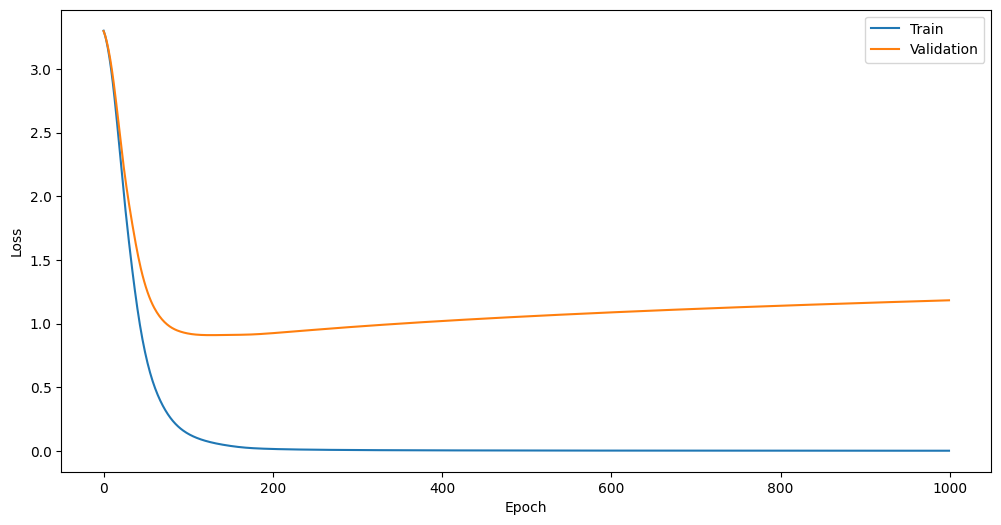

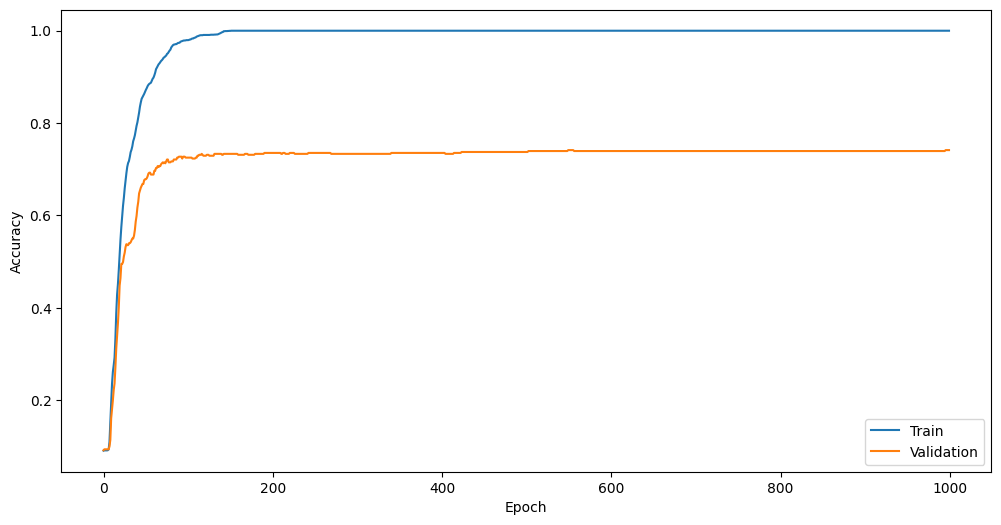

In [49]:
import matplotlib.pyplot as plt

x = data.x
train_y = data.y[data.train_mask]
val_y = data.y[data.val_mask]

learning_rate = 0.01
epochs = 1000
hidden_channels = 16
model = GCN(hidden_channels)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# the training loop
accs = []
losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    h, z = model(x, edge_index)
    train_h, train_z = h[data.train_mask], z[data.train_mask]
    loss = criterion(train_z, train_y)
    loss.backward()
    optimizer.step()

    acc = accuracy(train_z.argmax(dim=1), train_y)
    accs.append(acc)
    losses.append(loss.detach().numpy())

    model.eval()
    with torch.no_grad():
        val_h, val_z = h[data.val_mask], z[data.val_mask]
        val_acc = accuracy(val_z.argmax(dim=1), val_y)
        val_loss = criterion(val_z, val_y)
        val_accs.append(val_acc)
        val_losses.append(val_loss.detach().numpy())

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:>3}, Loss: {loss:.4f}, Accuracy: {acc*100:>6.2f}%")
    

plt.figure(figsize=(12, 6))
plt.plot(losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()